In [1]:
from astropy.io import fits
from astropy.table import Table

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
## The scripts to gather the data are inside 'scripts' folder

splus_gaia = Table.read('https://splus.cloud/files/splus_gaia.csv', format='csv')
df = splus_gaia.to_pandas()

In [4]:
splus_gaia

SOURCE_ID,ra,dec,parallax,parallax_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pseudocolour,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,teff_gspphot,logg_gspphot,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,bp_rp,bp_g,g_rp,phot_proc_mode,ID,RA,DEC,Field,B,A,CLASS_STAR,THETA,FWHM,e_r_PStotal,e_g_PStotal,e_i_PStotal,e_z_PStotal,e_u_PStotal,e_J0378_PStotal,e_J0395_PStotal,e_J0410_PStotal,e_J0430_PStotal,e_J0515_PStotal,e_J0660_PStotal,e_J0861_PStotal,r_PStotal,g_PStotal,i_PStotal,z_PStotal,u_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,J0660_PStotal,J0861_PStotal,sep
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str27,float64,float64,str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2449844367772722560,0.0002503348645434193,-0.8387389668357647,0.2561279979430445,0.19675764441490173,18.458457946777344,18.77886199951172,17.981124877929688,--,779.0472284637638,420.60260092930935,508.98885249313406,5736.00537109375,4.728899955749512,1.0349310636520386,13.690284729003906,11.543553352355957,0.7977371215820312,0.320404052734375,0.47733306884765625,0,DR4_3_STRIPE82-0001_0015831,0.0002497009908446466,-0.83867458696013,STRIPE82-0001,0.00027633359422907233,0.000283808505628258,0.979926347732544,-23.054519653320312,0.0004982531536370516,0.017354782670736313,0.02375425025820732,0.01878315955400467,0.028316406533122063,0.0552477166056633,0.055131103843450546,0.07710617780685425,0.0549740344285965,0.04656647518277168,0.05092255771160126,0.01840069144964218,0.032896071672439575,18.447179794311523,18.796445846557617,18.34921646118164,18.26189613342285,19.763717651367188,19.350244522094727,19.366924285888672,19.17885398864746,19.01011848449707,18.661975860595703,18.410642623901367,18.282794952392578,0.2317787834356434
2449824061167330176,0.0002983033255481499,-1.034325152190938,0.9922553498839123,0.08497484028339386,16.68805503845215,17.296892166137695,15.946711540222168,--,3978.5506946818755,1646.873628115922,3314.9255118628025,4524.87158203125,4.651000022888184,2.1662817001342773,8.701017379760742,13.789440155029297,1.3501806259155273,0.6088371276855469,0.7413434982299805,0,DR4_3_STRIPE82-0001_0010575,0.0002943139797876988,-1.034277789358206,STRIPE82-0001,0.0003401915600989014,0.00035865462268702686,0.9827288389205933,-47.943458557128906,0.00045421114191412926,0.005790070630609989,0.010717209428548813,0.005089063197374344,0.0059970379807055,0.059353578835725784,0.06682410091161728,0.06963768601417542,0.032365892082452774,0.0275427233427763,0.022967668250203133,0.006007954478263855,0.007775675039738417,16.62002944946289,17.568111419677734,16.29674530029297,16.116912841796875,20.030364990234375,19.75855255126953,19.396154403686523,18.521547317504883,18.3136043548584,17.52968406677246,16.480504989624023,16.158309936523438,0.17110976925250648
2738301239023951872,0.0006456433664899519,0.8097416453527122,1.5546639904202617,0.15466518700122833,17.898569107055664,19.03917694091797,16.878192901611328,--,1304.725075541893,330.9378287401216,1405.6628587021394,5094.2568359375,3.755500078201294,1.4808422327041626,8.602250099182129,9.763195037841797,2.1609840393066406,1.1406078338623047,1.020376205444336,0,DR4_3_STRIPE82-0002_0027468,0.000623464725577727,0.8097550310987973,STRIPE82-0002,0.00023834500461816788,0.0002740290074143559,0.9828724265098572,-83.48197937011719,0.00034791918005794287,0.011600738391280174,0.030059054493904114,0.0073776692152023315,0.00824861228466034,0.5576764345169067,3.8678622245788574,0.7665267586708069,0.32019883394241333,0.27584776282310486,0.06721800565719604,0.010815650224685669,0.01096648070961237,18.103282928466797,19.45471954345703,17.21022

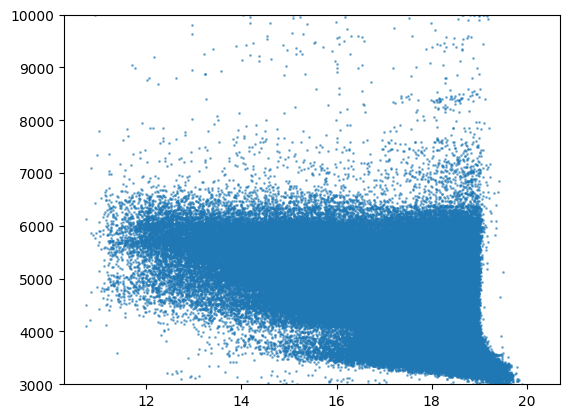

In [6]:
plt.scatter(df["r_PStotal"], df["teff_gspphot"], alpha=0.5, s=1)
plt.ylim(3000, 10000)
plt.show()

You can see that our target data ranges from 3000K to 6000K

So we can conlude that our model will be able to predict the temperature of the stars in this range

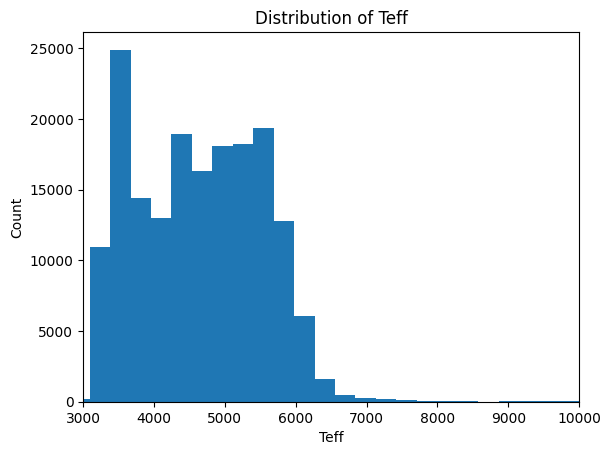

In [8]:
plt.hist(df["teff_gspphot"], bins=100)
plt.xlabel("Teff")
plt.ylabel("Count")
plt.title("Distribution of Teff")

plt.xlim(3000, 10000)

plt.show()

### Make some quality cuts

We apply quality cuts to select point-like sources (CLASS_STAR > 0.9) with reliable photometry (e_r_PStotal < 0.03). 

So this will be the target objects for our analysis.

In [9]:
df = df[
    (df["CLASS_STAR"] > 0.9) &
    (df["r_PStotal"] > 14) &
    (df["r_PStotal"] < 20) &
    (df["e_r_PStotal"] < 0.03)
]

In [10]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
# Remove duplicates
df_cleaned = df.drop_duplicates()

Missing values in each column:
parallax                     3582
parallax_error               3582
phot_g_mean_mag                 8
phot_bp_mean_mag             1779
phot_rp_mean_mag             1779
pseudocolour               173968
phot_g_mean_flux                8
phot_bp_mean_flux            1779
phot_rp_mean_flux            1779
teff_gspphot                35173
logg_gspphot                35173
phot_g_mean_flux_error          8
phot_bp_mean_flux_error      1779
phot_rp_mean_flux_error      1779
bp_rp                        1783
bp_g                         1779
g_rp                         1782
phot_proc_mode                  5
dtype: int64
Number of duplicate rows: 0


### Note

Notice that all the missing values in the table are from gaia. 

Now, we are going to use only teff_gspphot, so we can drop only the rows with missing values in this column.

In [11]:
print(f"Number of rows after before removing NaNs: {len(df_cleaned)}")
df_cleaned = df_cleaned[df_cleaned["teff_gspphot"].notna()]
print(f"Number of rows after removing NaN values: {len(df_cleaned)}")

Number of rows after before removing NaNs: 198994
Number of rows after removing NaN values: 163821


In [12]:
mag_cols = ['u_PStotal', 'g_PStotal', 'r_PStotal', 'i_PStotal', 'z_PStotal',
    'J0378_PStotal', 'J0395_PStotal', 'J0410_PStotal', 'J0430_PStotal',
    'J0515_PStotal', 'J0660_PStotal', 'J0861_PStotal']

# Function to plot histograms
def plot_histograms(columns, title, df, bins=50):
    n = len(columns)
    ncols = 4
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 3 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]
        df[col].hist(ax=ax, bins=bins, alpha=0.7)
        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Count')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

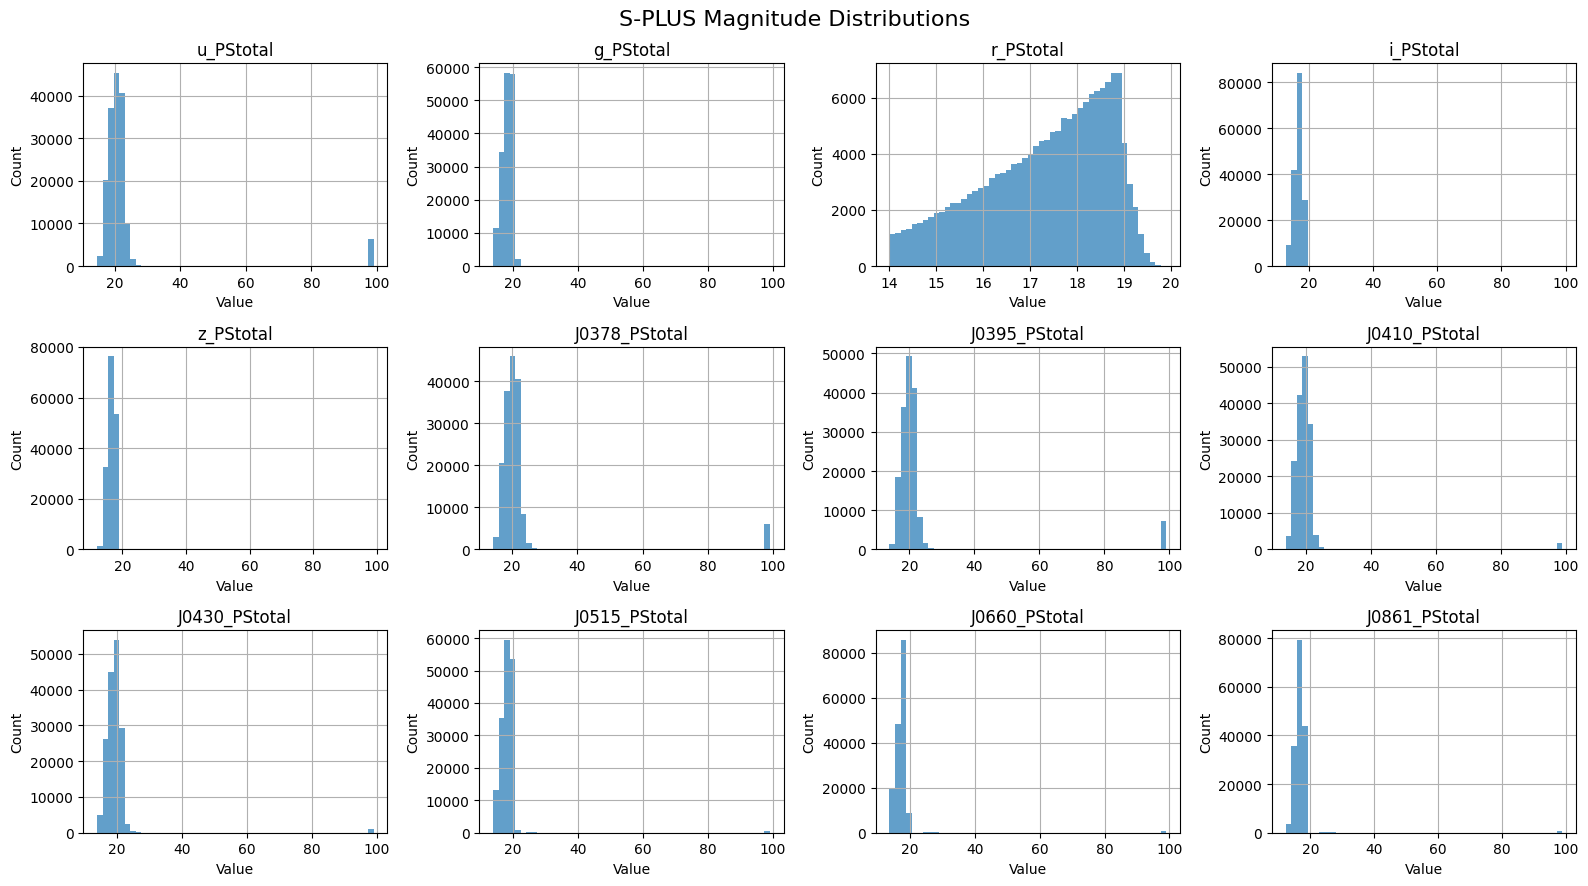

In [13]:
# Plot magnitudes
plot_histograms(mag_cols, 'S-PLUS Magnitude Distributions', df_cleaned)

In [14]:
## We can see there that are mags near 100, which is not possible. We will remove those
print("Lenght before removing missing mags: ", len(df_cleaned))

for col in mag_cols:
    df_cleaned = df_cleaned[df_cleaned[col] < 21]
    df_cleaned = df_cleaned[df_cleaned[col] > 14]
    
print("Lenght after removing missing mags: ", len(df_cleaned))

Lenght before removing missing mags:  163821
Lenght after removing missing mags:  92100


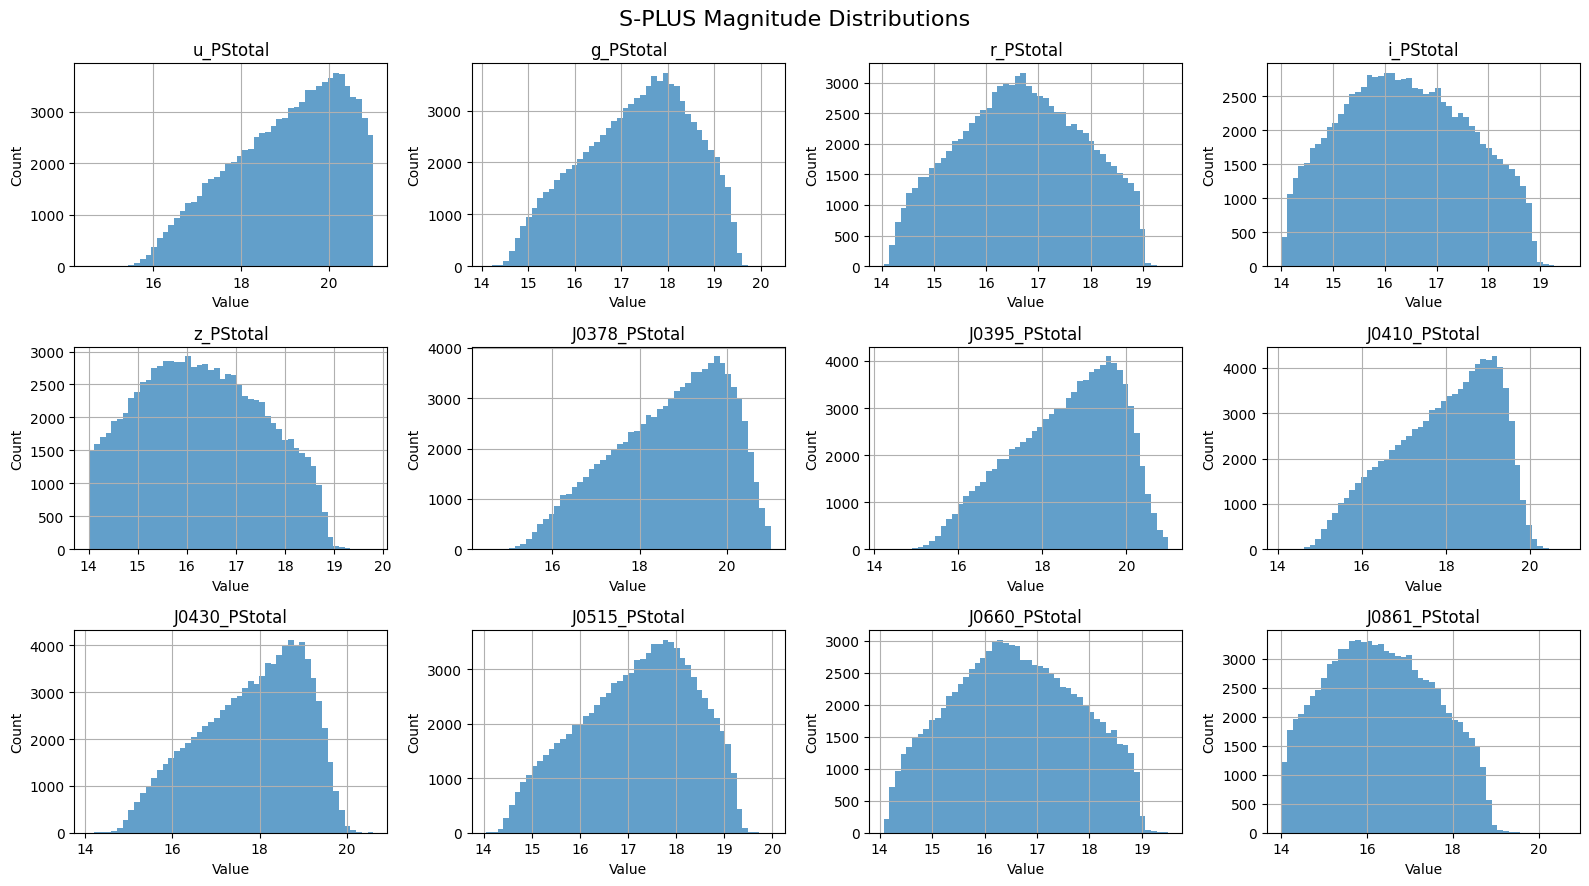

In [15]:
plot_histograms(mag_cols, 'S-PLUS Magnitude Distributions', df_cleaned)

### Define our features and target

We define our features as the magnitudes in the different bands and our target as the teff_gspphot (z).

In [16]:
# Define features and target
splus_mags = [
    'u_PStotal', 'g_PStotal', 'r_PStotal', 'i_PStotal', 'z_PStotal',
    'J0378_PStotal', 'J0395_PStotal', 'J0410_PStotal', 'J0430_PStotal',
    'J0515_PStotal', 'J0660_PStotal', 'J0861_PStotal',
    'e_u_PStotal', 'e_g_PStotal', 'e_r_PStotal', 'e_i_PStotal',
    'e_z_PStotal', 'e_J0378_PStotal', 'e_J0395_PStotal',
    'e_J0410_PStotal', 'e_J0430_PStotal', 'e_J0515_PStotal',
    'e_J0660_PStotal', 'e_J0861_PStotal'
]
target = 'teff_gspphot'

In [17]:
df_cleaned = df_cleaned[splus_mags + [target]]
df_cleaned

,u_PStotal,g_PStotal,r_PStotal,i_PStotal,z_PStotal,J0378_PStotal,J0395_PStotal,J0410_PStotal,J0430_PStotal,J0515_PStotal,...,e_i_PStotal,e_z_PStotal,e_J0378_PStotal,e_J0395_PStotal,e_J0410_PStotal,e_J0430_PStotal,e_J0515_PStotal,e_J0660_PStotal,e_J0861_PStotal,teff_gspphot
0,19.763718,18.796446,18.447180,18.349216,18.261896,19.350245,19.366924,19.178854,19.010118,18.661976,...,0.018783,0.028316,0.055131,0.077106,0.054974,0.046566,0.050923,0.018401,0.032896,5736.005371
1,20.030365,17.568111,16.620029,16.296745,16.116913,19.758553,19.396154,18.521547,18.313604,17.529684,...,0.005089,0.005997,0.066824,0.069638,0.032366,0.027543,0.022968,0.006008,0.007776,4524.871582
3,16.535213,15.202480,14.714741,14.575050,14.518099,16.161364,16.118246,15.646839,15.584898,15.027861,...,0.001895,0.002277,0.010329,0.013738,0.008998,0.008917,0.005567,0.002304,0.003140,5450.434570
5,18.867445,17.554789,17.029985,16.859510,16.802652,18.561947,18.463997,18.043125,17.915268,17.372200,...,0.006132,0.008328,0.040925,0.053543,0.033113,0.031354,0.018292,0.007197,0.010883,5228.993652
6,18.246979,17.295582,16.923988,16.819798,16.792551,17.820097,17.739979,17.516357,17.430685,17.141411,...,0.006895,0.009360,0.018496,0.023423,0.017794,0.016383,0.018881,0.007563,0.011760,5947.934082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213981,20.592125,18.933407,18.132133,17.734743,17.544149,20.142765,20.077528,19.484119,19.657984,18.618290,...,0.009956,0.013428,0.134841,0.163985,0.087385,0.100886,0.039007,0.017740,0.025474,4796.831543
213983,20.493351,18.357002,17.403687,16.938944,16.727791,20.008743,19.551291,19.091082,18.854956,18.056938,...,0.006081,0.007449,0.109410,0.110438,0.063399,0.051749,0.025074,0.010716,0.013682,4923.850586
213987,17.822289,16.043465,15.277490,14.952024,14.802002,17.326164,17.182749,16.601421,16.453659,15.763599,...,0.002865,0.003115,0.023715,0.036550,0.017994,0.015455,0.008374,0.003440,0.004149,5800.614258
213988,20.418509,18.294464,17.325752,16.921869,16.721437,20.037703,19.899069,19.095871,18.887007,18.029640,...,0.006253,0.007772,0.106401,0.143179,0.065644,0.054393,0.025291,0.012983,0.014597,4483.823730


### Train/Test Split

We split the data into training (80%) and evaluation (20%) subsets to train models and evaluate their performance.

The evaluation will be used at the end of the notebook to evaluate the performance of our model.

In [21]:
from sklearn.model_selection import train_test_split
train_df, eval_df = train_test_split(df_cleaned, test_size=0.2, random_state=42)
train_df.shape, eval_df.shape

((73680, 25), (18420, 25))

In [22]:
# Features and target
X = train_df[splus_mags].values
y = train_df[target].values

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (73680, 24)
y shape:  (73680,)


### Now let's train our model

We will use the **Random Forest Regressor** and **Histogram-based Gradient Boosting Regression Tree** from sklearn to train our model.

In [47]:
from sklearn.ensemble import RandomForestRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
rf_model.fit(X, y)

from sklearn.ensemble import HistGradientBoostingRegressor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html
hg_model = HistGradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.1,
    max_iter=100, 
    random_state=42
)
hg_model.fit(X, y)

HistGradientBoostingRegressor(random_state=42)

### Now let's evaluate the model

Evaluation Metrics: MAE and RMSE

To evaluate the model’s predictions, we use two common regression metrics:

- **MAE (Mean Absolute Error):**  
  Measures the average absolute difference between predicted and true values.
  
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

- **RMSE (Root Mean Squared Error):**  
  Penalizes larger errors more than MAE by squaring the differences before averaging.
  
$$
\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

Both metrics are in the same unit as the target variable (`Teff`, in our case) and help assess how well the model is performing.

In [48]:
X_eval = eval_df[splus_mags].values
y_eval = eval_df[target].values

In [49]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np

print(f"Predicting {len(X_eval)} samples...")

# Predict on the evaluation set (never seen by the model)
rf_predict = rf_model.predict(X_eval)
hg_predict = hg_model.predict(X_eval)
print("Random Forest Predictions:     ", rf_predict[:5], "...")
print("HistGrad Boosting Predictions: ", hg_predict[:5], "...")

# Evaluate
rf_mae = mean_absolute_error(y_eval, rf_predict)
rf_rmse = root_mean_squared_error(y_eval, rf_predict)
print("Random Forest MAE:           ", round(rf_mae, 3), "K")
print("Random Forest RMSE:          ", round(rf_rmse, 3), "K")

# Evaluate Hist Gradient Boosting
hg_mae = mean_absolute_error(y_eval, hg_predict)
hg_rmse = root_mean_squared_error(y_eval, hg_predict)
print("Hist Gradient Boosting MAE:  ", round(hg_mae, 3), "K")
print("Hist Gradient Boosting RMSE: ", round(hg_rmse, 3), "K")

Predicting 18420 samples...
Random Forest Predictions:      [4927.45097847 5628.35956391 5509.25231829 5952.38756954 5579.41310324] ...
HistGrad Boosting Predictions:  [4920.50834256 5589.98006044 5515.92329486 5910.39449388 5478.26558617] ...
Random Forest MAE:            116.311 K
Random Forest RMSE:           236.62 K
Hist Gradient Boosting MAE:   120.104 K
Hist Gradient Boosting RMSE:  238.353 K


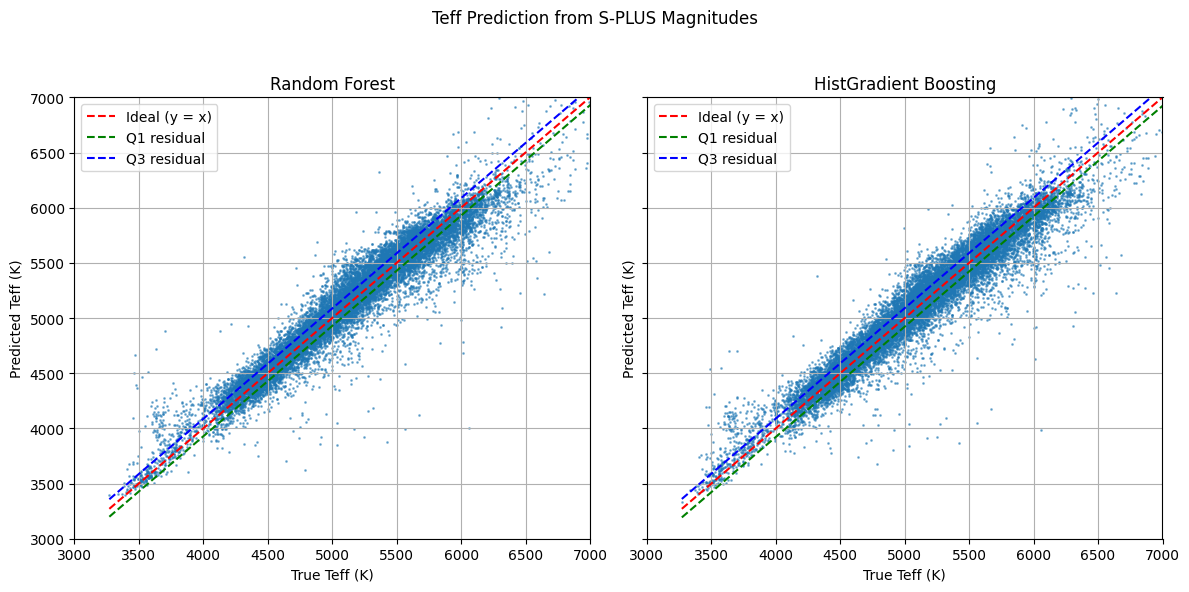

In [52]:
# Define quartile function
def plot_scatter_with_quartiles(ax, y_true, y_pred, title):
    ax.scatter(y_true, y_pred, alpha=0.5, s=1)
    
    # Ideal line
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label="Ideal (y = x)")
    
    # Quartile lines
    residuals = y_pred - y_true
    q1 = np.percentile(residuals, 25)
    q3 = np.percentile(residuals, 75)
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min() + q1, y_true.max() + q1], 'g--', label='Q1 residual')
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min() + q3, y_true.max() + q3], 'b--', label='Q3 residual')
    
    ax.set_xlim(3000, 7000)
    ax.set_ylim(3000, 7000)
    ax.set_xlabel("True Teff (K)")
    ax.set_ylabel("Predicted Teff (K)")
    ax.set_title(title)
    ax.grid(True)
    ax.legend()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

plot_scatter_with_quartiles(axes[0], y_eval, rf_predict, "Random Forest")
plot_scatter_with_quartiles(axes[1], y_eval, hg_predict, "HistGradient Boosting")

plt.suptitle("Teff Prediction from S-PLUS Magnitudes")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("teff_prediction_comparison.png", dpi=150)
plt.show()

### Improvements for the future and notes

1. Feature Engineering
	•	Use colors (e.g. g-r, r-i) instead of raw magnitudes — they often correlate better with Teff.
	•	Consider dimensionality reduction (e.g. PCA) if using many bands.

2. Outlier Analysis
	•	Add a step to analyze prediction outliers — are they low SNR? border-line stars? unresolved blends?

3. Train/Test Leakage
	•	Ensure that there’s no spatial overlap between training and test sets if the goal is generalization to new sky regions.

4. Data Volume and Bias
	•	Our current data is filtered to “high quality” sources — in production, models should handle lower quality data, or include quality flags in the prediction process.

5. Calibration vs Ground Truth
	•	Teff is treated as ground truth, but what is its source and uncertainty? In a real scenario, modeling label noise is also important.

6. Uncertainty in Prediction
	•	Consider models that return uncertainty estimates in Teff, not just point predictions (e.g. quantile regression, Bayesian models).

7.  Deployment-Readiness
	•	Exporting the model and wrapping in a pipeline for real-time inference (e.g. for catalog-level processing) is another consideration for production use.


And a lot of other things that we can do to improve our model!